In [18]:
#%% packages
from transformers import AutoModelForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from datasets import DatasetDict

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.nn.functional import cross_entropy
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier


In [19]:
try:
    yelp_hidden_states = joblib.load('model/yelp_hidden_states.joblib')
except FileNotFoundError:
    print("Le fichier yelp_hidden_states.joblib est introuvable.")


In [20]:
#%% Model and Tokenizer
model_name = 'distilbert-base-uncased'
device = 'cuda'
num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
#%% Dataset
train_ds = yelp_hidden_states.select(range(0, 800))
eval_ds = yelp_hidden_states.select(range(800, 1000))
print(train_ds[0]['input_ids'].shape)
print(eval_ds[0]['input_ids'].shape)
print(yelp_hidden_states[800]['input_ids'].shape)


torch.Size([512])
torch.Size([512])
torch.Size([512])


In [22]:
#%% DatasetDict
yelp_ds_dict = DatasetDict({'train': train_ds, 'test':eval_ds})


In [25]:
#%% Trainer Arguments
batch_size = 8  # adapt BS to fit into memory
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    learning_rate=2e-5,              # learning rate
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=batch_size,  # batch size per device during training
    per_device_eval_batch_size=batch_size,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    disable_tqdm=False,
    push_to_hub=False,
    save_strategy='epoch',
    log_level='error',
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
        report_to="none",


)

In [26]:
#%% Trainer
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=yelp_ds_dict['train'], eval_dataset=yelp_ds_dict['test'])
trainer.train()

Step,Training Loss
500,1.280100
1000,0.301100
1500,0.020000
2000,0.002500


TrainOutput(global_step=2000, training_loss=0.40090629905462266, metrics={'train_runtime': 877.6029, 'train_samples_per_second': 18.231, 'train_steps_per_second': 2.279, 'total_flos': 2119591772160000.0, 'train_loss': 0.40090629905462266, 'epoch': 20.0})

In [27]:

# %% get losses
trainer.evaluate()

{'eval_loss': 2.5664117336273193,
 'eval_runtime': 2.8776,
 'eval_samples_per_second': 69.502,
 'eval_steps_per_second': 8.688,
 'epoch': 20.0}

In [28]:
# %% calculate predictions
preds = trainer.predict(yelp_ds_dict['test'])


In [29]:
# %%
preds.metrics

{'test_loss': 2.5664117336273193,
 'test_runtime': 2.9894,
 'test_samples_per_second': 66.904,
 'test_steps_per_second': 8.363}

In [30]:
# %%
np.argmax(preds.predictions, axis=1)

array([0, 2, 4, 4, 3, 3, 3, 2, 3, 1, 4, 4, 4, 1, 3, 1, 3, 3, 2, 1, 0, 2,
       2, 1, 2, 2, 3, 1, 0, 3, 2, 2, 2, 2, 2, 3, 3, 4, 3, 2, 3, 4, 3, 3,
       2, 2, 3, 4, 4, 2, 4, 4, 4, 1, 2, 3, 4, 1, 3, 4, 1, 3, 2, 2, 1, 2,
       3, 0, 4, 1, 4, 4, 2, 2, 1, 1, 1, 3, 2, 3, 1, 1, 3, 2, 3, 2, 2, 1,
       1, 3, 4, 2, 3, 1, 1, 2, 2, 2, 3, 2, 1, 1, 1, 2, 3, 1, 1, 1, 0, 3,
       1, 3, 2, 3, 3, 3, 1, 2, 2, 3, 4, 3, 0, 2, 3, 2, 3, 1, 2, 1, 4, 4,
       3, 3, 0, 1, 2, 3, 1, 3, 0, 1, 4, 3, 0, 4, 4, 2, 2, 3, 3, 3, 3, 1,
       2, 2, 1, 4, 2, 2, 4, 1, 4, 1, 0, 4, 4, 1, 0, 2, 2, 3, 4, 4, 4, 2,
       0, 1, 1, 1, 1, 0, 0, 2, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3,
       4, 4])

<Axes: >

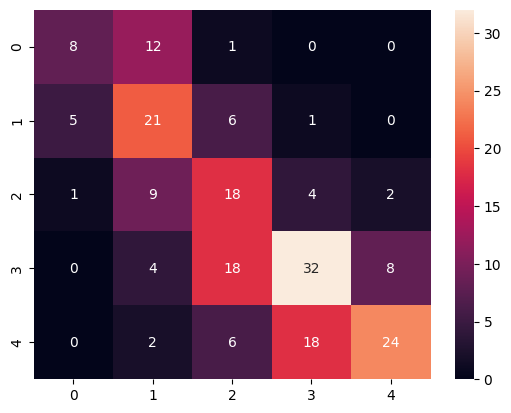

In [31]:
# %% confusion matrix
true_classes = yelp_ds_dict['test']['label']
preds_classes = np.argmax(preds.predictions, axis=1)
conf_mat = confusion_matrix(true_classes, preds_classes)
sns.heatmap(conf_mat, annot=True)

In [32]:
# %% accuracy
accuracy_score(true_classes, preds_classes)

0.515

In [33]:
# %% baseline classifier training

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(yelp_ds_dict['train']['label'], yelp_ds_dict['train']['label'])


DummyClassifier(strategy='most_frequent')

In [34]:
# %% baseline classifier accuracy
dummy_clf.score(yelp_ds_dict['test']['label'], yelp_ds_dict['test']['label'])


0.165

In [36]:
# Vérification du périphérique (GPU ou CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Chargement du modèle sur le périphérique approprié
model = AutoModel.from_pretrained(model_name).to(device)

# Si vous souhaitez déplacer le modèle vers le GPU explicitement (si nécessaire)
model_gpu = model.to('cuda')

In [38]:
# Déplacer les entrées vers le même périphérique que le modèle (GPU ou CPU)
inputs = {
    'input_ids': yelp_ds_dict['test']['input_ids'].to(device),
    'attention_mask': yelp_ds_dict['test']['attention_mask'].to(device)
}

# Inference avec le modèle sur le périphérique correct
with torch.no_grad():
    outputs = model_gpu(**inputs)


In [51]:
# Assuming the last hidden state has the shape [batch_size, sequence_length, hidden_size]
# Typically, the [CLS] token is at index 0 for classification tasks

# Extract the [CLS] token's hidden state (batch_size, hidden_size)
cls_hidden_state = outputs.last_hidden_state[:, 0, :]

# Apply a linear layer (classification head) to the [CLS] token's hidden state
# Let's assume you have a linear layer for classification:
classification_head = torch.nn.Linear(outputs.last_hidden_state.size(-1), num_labels).to(device)

logits = classification_head(cls_hidden_state)

# Now, you can use the logits for prediction
pred_labels = torch.argmax(logits, dim=1)

# Loss calculation
loss = torch.nn.functional.cross_entropy(logits, yelp_ds_dict['test']['label'].to(device), reduction='none')


In [55]:
# Assuming pred_labels and loss are on the GPU
df_individual_reviews = pd.DataFrame({
    'text': yelp_ds_dict['test']['text'],
    'label': yelp_ds_dict['test']['label'],
    'pred_label': pred_labels.cpu().numpy(),  # Move to CPU and convert to NumPy
    'loss': loss.cpu().detach().numpy()  # Move to CPU, detach and convert to NumPy
}).sort_values('loss', ascending=False).reset_index(drop=True)

df_individual_reviews

,text,label,pred_label,loss
0,Casbah is definitely my favorite restaurant in...,4,3,2.081630
1,Casbah is fast becoming my favorite restaurant...,4,2,2.078436
2,"OK, so I admit that I was underwhelmed by Cafe...",4,3,2.057575
3,My wife and I go to Casbah every year for my b...,4,3,2.046717
4,I was somewhat worried about going here since ...,4,3,2.027635
...,...,...,...,...
195,I didn't realize that Quiet Storm was a comple...,3,3,1.242142
196,"There is a disconnect here between this name, ...",3,3,1.236836
197,Visited for brunch again on a rainy winter Sun...,3,3,1.228379
198,"This is a good co-op, with a generous selectio...",3,3,1.216772


<Axes: xlabel='label', ylabel='loss'>

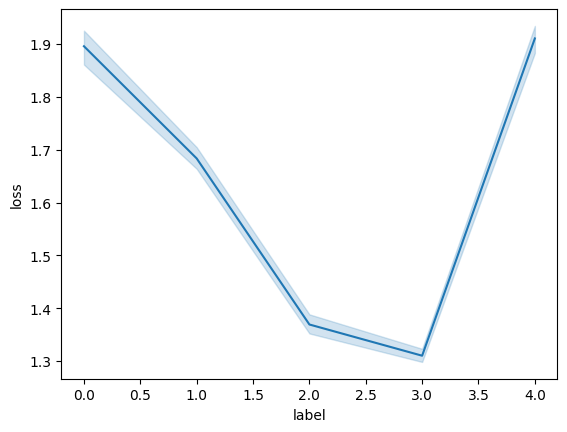

In [56]:
# %%
sns.lineplot(data=df_individual_reviews, x='label', y='loss')